##Import

In [7]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

print("Tensorflow version ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: ', device_name)

Tensorflow version  2.6.0
Found GPU at:  /device:GPU:0


## Load data

Load training data from Keras library




### MNIST

In [8]:
def load_data_MNIST():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = mnist.load_data()

    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    ntest = Xtest.shape[0]
    num_classes = max(Ytrain) + 1
    print("Training input: " , Xtrain.shape)
    print("Training output: " , Ytrain.shape)
    print("Test input: "  , Xtest.shape)
    print("Test output: " , Ytest.shape)
    print("Input shape: " , input_shape)
    print("Number of classes: " , num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    # reshape input in 4D array
    Xtrain = Xtrain.reshape(ninput,imgsize[0],imgsize[1],1)
    Xtest = Xtest.reshape(ntest,imgsize[0],imgsize[1],1)
    
    # Transform output to one hot encoding
    Ytrain = to_categorical(Ytrain, num_classes)
    Ytest = to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain_mnist,Ytrain_mnist,Xtest_mnist,Ytest_mnist,input_shape_mnist,num_classes_mnist] = load_data_MNIST()

Training input:  (60000, 28, 28)
Training output:  (60000,)
Test input:  (10000, 28, 28)
Test output:  (10000,)
Input shape:  (28, 28, 1)
Number of classes:  10


#### Show random image



4


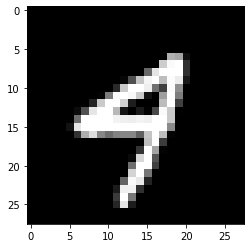

In [9]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain_mnist.shape[0])
image = Xtrain_mnist[i]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))

label = Ytrain_mnist[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(pixels, cmap='gray')
plt.show()


### CIFAR 10

In [10]:
def load_data_CIFAR10():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = keras.datasets.cifar10.load_data()

    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3])
    ntest = Xtest.shape[0]
    num_classes = 10
    print("Training input: " , Xtrain.shape)
    print("Training output: " , Ytrain.shape)
    print("Test input: "  , Xtest.shape)
    print("Test output: " , Ytest.shape)
    print("Input shape: " , input_shape)
    print("Number of classes: " , num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    # reshape input in 4D array
    Xtrain = Xtrain.reshape(ninput,imgsize[0],imgsize[1],3)
    Xtest = Xtest.reshape(ntest,imgsize[0],imgsize[1],3)
    
    # Transform output to one-out-of-n encoding
    Ytrain = to_categorical(Ytrain.tolist()[:], num_classes)
    Ytest = to_categorical(Ytest.tolist()[:], num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain_cifar10,Ytrain_cifar10,Xtest_cifar10,Ytest_cifar10,input_shape_cifar10,num_classes_cifar10] = load_data_CIFAR10()

Training input:  (50000, 32, 32, 3)
Training output:  (50000, 1)
Test input:  (10000, 32, 32, 3)
Test output:  (10000, 1)
Input shape:  (32, 32, 3)
Number of classes:  10


#### Show random image



8


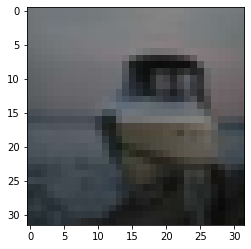

In [11]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain_cifar10.shape[0])
image = Xtrain_cifar10[i]
image = np.array(image, dtype='float')
pixels = image.reshape((32, 32, 3))

label = Ytrain_cifar10[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(image)
plt.show()


## Custom Softmax Loss Function

### 1) L1 Loss

In [12]:
@tf.function
def l1_loss(y_true, y_pred):
  L1_loss_calc = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred)) ,axis = 1, keepdims=True)
  return tf.divide(tf.reduce_sum(L1_loss_calc),L1_loss_calc.shape[0])

### 2) L2 Loss

In [13]:
@tf.function
def l2_loss(y_true, y_pred):
  L2_loss = tf.norm(tf.subtract(y_true, y_pred), axis= 1) ** 2
  return tf.divide(tf.reduce_sum(L2_loss),L2_loss.shape[0])

### 3) Expectation Loss

In [14]:
@tf.function
def expectation_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)
  # Apply L1 loss
  L1_loss = tf.reduce_sum(tf.abs(tf.subtract(y_true, y_pred_ratio)) ,axis = 1, keepdims=True)
  return tf.divide(tf.reduce_sum(L1_loss),L1_loss.shape[0])

### 4) Regularised Expectation Loss

In [15]:
@tf.function
def regularized_expectation_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)
  # Apply L2 loss
  L2_loss = tf.norm(tf.subtract(y_true, y_pred_ratio), axis= 1) ** 2
  return tf.divide(tf.reduce_sum(L2_loss),L2_loss.shape[0])

### 5) Chebyshev loss

In [16]:
@tf.function
def chebyshev_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)
  # Apply cheb loss
  cheb_loss = tf.reduce_max(tf.abs(tf.subtract(y_true, y_pred_ratio)) ,axis = 1, keepdims=True)
  return tf.divide(tf.reduce_sum(cheb_loss),cheb_loss.shape[0])

### 6) hinge (margin) loss

In [17]:
@tf.function
def hinge_loss(y_true, y_pred):
  y_product = tf.math.multiply(y_true,y_pred)
  max_second_arg = tf.constant(0.5) - y_product
  max_compare = tf.math.maximum(tf.constant(0.0), max_second_arg)

  y_product_red = tf.reduce_sum(max_compare,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  return tf.divide(tf.reduce_sum(y_product_red_abs),y_product_red_abs.shape[0])

### 7) Squared hinge (margin) loss

In [18]:
@tf.function
def squared_hinge_loss(y_true, y_pred):
  y_product = tf.math.multiply(y_true,y_pred)
  max_second_arg = tf.constant(0.5) - y_product
  max_compare = tf.math.maximum(tf.constant(0.0), max_second_arg) ** 2

  y_product_red = tf.reduce_sum(max_compare,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  return tf.divide(tf.reduce_sum(y_product_red_abs),y_product_red_abs.shape[0])

### 8) Cubed hinge (margin) loss

In [19]:
@tf.function
def cubed_hinge_loss(y_true, y_pred):
  y_product = tf.math.multiply(y_true,y_pred)
  max_second_arg = tf.constant(0.5) - y_product
  max_compare = tf.math.maximum(tf.constant(0.0), max_second_arg) ** 3

  y_product_red = tf.reduce_sum(max_compare,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  return tf.divide(tf.reduce_sum(y_product_red_abs),y_product_red_abs.shape[0])

### 9) Log (cross entropy) loss

In [20]:
@tf.function
def cross_entropy_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)

  # Apply Cross Entropy
  #y_pred[sample][i] = tf.math.log(y_pred[sample][i])
  y_log = tf.math.log(y_pred_ratio)
  y_product = tf.math.multiply(y_true,y_log)
  y_product_red = tf.reduce_sum(y_product,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  return tf.divide(tf.reduce_sum(y_product_red_abs),y_product_red_abs.shape[0])

### 10) Squared log loss

In [21]:
@tf.function
def squared_log_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)

  # Apply Cross Entropy
  #y_pred[sample][i] = tf.math.log(y_pred[sample][i])
  y_log = tf.math.log(y_pred_ratio)
  y_square_product = tf.math.square(tf.math.multiply(y_true,y_log))
  y_product_red = tf.reduce_sum(y_square_product,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  return tf.divide(tf.reduce_sum(y_product_red_abs),y_product_red_abs.shape[0])

### 11) Tanimoto loss

In [22]:
@tf.function
def tanimoto_loss(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)

  # Apply Cross Entropy (Numerator Part)
  y_product = tf.math.multiply(y_true,y_pred_ratio)
  y_product_red = tf.reduce_sum(y_product,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  true_label_norm = tf.reshape(tf.norm(y_true, axis=1) ** 2, [y_pred.shape[0],1])
  predicted_prob_norm = tf.reshape(tf.norm(y_pred_ratio, axis=1) ** 2, [y_pred.shape[0],1])
  denominator_sum = predicted_prob_norm + true_label_norm - y_product_red_abs

  tanimoto_loss_eq = tf.divide(y_product_red_abs,tf.abs(denominator_sum))

  return tf.divide(tf.reduce_sum(tanimoto_loss_eq),tanimoto_loss_eq.shape[0])

### 12) Cauchy-Schwarz Divergence

In [23]:
@tf.function
def cauchy_schwarz_divergence(y_true, y_pred):
  # Apply Softmax
  y_pred_sum = tf.reduce_sum(y_pred,axis = 1, keepdims=True)
  y_pred_ratio = tf.divide(y_pred,y_pred_sum)

  # Apply Cross Entropy (Numerator Part)
  y_product = tf.math.multiply(y_true,y_pred_ratio)
  y_product_red = tf.reduce_sum(y_product,axis = 1, keepdims=True)
  y_product_red_abs = tf.abs(y_product_red)

  true_label_norm = tf.reshape(tf.norm(y_true, axis=1), [y_pred.shape[0],1])
  predicted_prob_norm = tf.reshape(tf.norm(y_pred_ratio, axis=1), [y_pred.shape[0],1])
  denominator_product = tf.math.multiply(predicted_prob_norm, true_label_norm)

  cauchy_schwarz_eq = tf.abs(tf.math.log(tf.divide(y_product_red_abs,denominator_product)))

  return tf.divide(tf.reduce_sum(cauchy_schwarz_eq),cauchy_schwarz_eq.shape[0])

## NN Sequential Models


In [24]:
def noise_app(y_train, percentage):
  y_train_noisy = np.copy(y_train)
  samples_size = int(percentage * len(y_train_noisy))
  random_samples = np.random.choice(len(y_train_noisy), size=samples_size, replace=False)
  b = y_train[random_samples]
  np.random.shuffle(b)
  y_train_noisy[random_samples] = b
  return y_train_noisy

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
#from keras.layers.normalization import BatchNormalization
from keras import regularizers
#from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

##########################################
##########################################
####### STUDY CONFIGURATIONS
##########################################
##########################################
current_model = 'cifar10'
apply_noise = True

# Model Parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003)
num_of_classes = 10
if current_model == 'cifar10':
  #epochs = 100000
  #batch_size = 100
  epochs = 50
  batch_size = 100
  input_shape = input_shape_cifar10
  Xtrain = Xtrain_cifar10
  Ytrain = Ytrain_cifar10
  Xtest = Xtest_cifar10
  Ytest = Ytest_cifar10

elif current_model == 'mnist':
  #epochs = 100000
  #batch_size = 100
  epochs = 50
  batch_size = 100
  input_shape = input_shape_mnist
  Xtrain = Xtrain_mnist
  Ytrain = Ytrain_mnist
  Xtest = Xtest_mnist
  Ytest = Ytest_mnist

print("Model Selected: ", current_model)
print("epochs: ", epochs)
print("batch_size: ", batch_size)
print("input_shape: ", input_shape)

Model Selected:  cifar10
epochs:  50
batch_size:  100
input_shape:  (32, 32, 3)


### MNIST Model

In [26]:
def MNIST_Model(input_shape):
  print('MNIST model')
  num_classes = 10
  model = Sequential()

  model.add(Flatten(input_shape= input_shape))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax'))

  return model

### CIFAR10 Model

In [27]:
def CIFAR10_Model(input_shape):
    
    print('CIFAR 10 model')
    num_classes = 10
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

### Loss Function Assignment

In [28]:
loss_functions_array = [l1_loss, l2_loss, expectation_loss, regularized_expectation_loss, chebyshev_loss, \
                        hinge_loss, squared_hinge_loss, cubed_hinge_loss, cross_entropy_loss, squared_log_loss, \
                        tanimoto_loss, cauchy_schwarz_divergence]
loss_functions_array_names = ['l1_loss', 'l2_loss', 'expectation_loss', 'regularized_expectation_loss', 'chebyshev_loss', \
                        'hinge_loss', 'squared_hinge_loss', 'cubed_hinge_loss', 'cross_entropy_loss', 'squared_log_loss', \
                        'tanimoto_loss', 'cauchy_schwarz_divergence']

## Train

In [ ]:
history_arr = []
noise_arr = []
noise_percentages = [0.1, 0.2, 0.4, 0.5]

if apply_noise:
  print("Noise Study is Applied")
  for noise_per in noise_percentages:
    print("Noise Percentage: ", noise_per)
    y_train_noisy = noise_app(Ytrain, noise_per)
    for loss_fun_index, loss_fun in enumerate(loss_functions_array):
      print("Loss Function Applied:" , loss_functions_array_names[loss_fun_index])
      if current_model == 'cifar10':
        model = CIFAR10_Model(input_shape)
      elif current_model == 'mnist':
        model = MNIST_Model(input_shape)
      model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
      history = model.fit(Xtrain, y_train_noisy, batch_size=batch_size, epochs=epochs, validation_data = (Xtest,Ytest))
      history_arr.append(history)
    noise_arr.append(history_arr)
    history_arr = []
else:
  print("Noise Study is NOT Applied")
  for loss_fun_index, loss_fun in enumerate(loss_functions_array):
    print("Loss Function Applied:" , loss_functions_array_names[loss_fun_index])
    if current_model == 'cifar10':
      model = CIFAR10_Model(input_shape)
    elif current_model == 'mnist':
      model = MNIST_Model(input_shape)
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data = (Xtest,Ytest))
    history_arr.append(history)

##Plot results

In [ ]:
import matplotlib.pyplot as plt

plot_width = 7
plot_height = 6

if apply_noise:
  for noise_per_index in range(len(noise_percentages)):
    
    # summarize history for accuracy
    plt.figure().set_figwidth(plot_width)
    plt.figure().set_figheight(plot_height)
    for history in noise_arr[noise_per_index]:
      plt.plot(history.history['accuracy'])
    if current_model == 'cifar10':
      title_str = 'model accuracy CIFAR10 with noise: ' + str(noise_percentages[noise_per_index])
      plt.title(title_str)
    elif current_model == 'mnist':
      title_str = 'model accuracy MNIST with noise: ' + str(noise_percentages[noise_per_index])
      plt.title(title_str)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.15, 0.4)
    plt.legend(loss_functions_array_names, bbox_to_anchor=(1.6, 0), loc='lower right')
    plt.show()

    # summarize history for Test Accuracy
    plt.figure().set_figwidth(plot_width)
    plt.figure().set_figheight(plot_height)
    for history in noise_arr[noise_per_index]:
      plt.plot(history.history['val_accuracy'])
    if current_model == 'cifar10':
      title_str = 'model Test Accuracy CIFAR10 with noise: ' + str(noise_percentages[noise_per_index])
      plt.title(title_str)
    elif current_model == 'mnist':
      title_str = 'model Test Accuracy MNIST with noise: ' + str(noise_percentages[noise_per_index])
      plt.title(title_str)
    plt.ylabel('Test Accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.25, 0.65)
    plt.legend(loss_functions_array_names, bbox_to_anchor=(1.6, 0), loc='lower right')
    plt.show()

else:
  # summarize history for accuracy
  plt.figure().set_figwidth(plot_width)
  plt.figure().set_figheight(plot_height)
  for history in history_arr:
    plt.plot(history.history['accuracy'])
  if current_model == 'cifar10':
    plt.title('model accuracy CIFAR10')
  elif current_model == 'mnist':
    plt.title('model accuracy MNIST')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.ylim(0.9, 1.0)
  plt.legend(loss_functions_array_names, bbox_to_anchor=(1.6, 0), loc='lower right')
  plt.show()

  # summarize history for Test Accuracy
  plt.figure().set_figwidth(plot_width)
  plt.figure().set_figheight(plot_height)
  for history in history_arr:
    plt.plot(history.history['val_accuracy'])
  if current_model == 'cifar10':
    plt.title('model Test Accuracy CIFAR10')
  elif current_model == 'mnist':
    plt.title('model Test Accuracy MNIST')
  plt.ylabel('Test Accuracy')
  plt.xlabel('epoch')
  plt.ylim(0.9, 1.0)
  plt.legend(loss_functions_array_names, bbox_to_anchor=(1.6, 0), loc='lower right')
  plt.show()